In [1]:
from tensorflow.keras.layers import Conv2D, BatchNormalization, Activation, MaxPool2D, Conv2DTranspose, Concatenate, Input,Dense
from tensorflow.keras import layers
from tensorflow.keras.models import Model
import tensorflow as tf
from keras import backend as k
import numpy as np
from tqdm import tqdm
import os
import matplotlib.pyplot as plt
from tqdm.auto import trange, tqdm
from keras.datasets import mnist, fashion_mnist
import pandas as pd

for gpu in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(gpu, True)

1. We load mnist data and get 10 images each representing a number.

In [2]:
# Load data.
(x_train, y_train), (x_test, y_test) = mnist.load_data()
Xt = x_train[pd.DataFrame(y_train).drop_duplicates().index]

# Normalize data.
Xt = Xt / np.max(Xt)

Xt = Xt.reshape(-1, 28, 28, 1)
Xt.shape

(10, 28, 28, 1)

2. We add noise linearly to each image for total 1000 timesteps, and get the  noisy image and noise for each corrosponding image and time step.

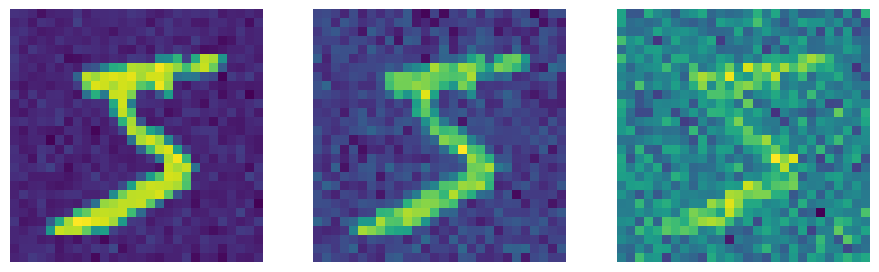

In [3]:
timesteps = 1000

# create a fixed beta schedule
beta = np.linspace(0.0001, 0.02, timesteps)

# this will be used as discussed in the reparameterization trick
alpha = 1 - beta
alpha_bar = np.cumprod(alpha, 0)
alpha_bar = np.concatenate((np.array([1.]), alpha_bar[:-1]), axis=0)
sqrt_alpha_bar = np.sqrt(alpha_bar)
one_minus_sqrt_alpha_bar = np.sqrt(1-alpha_bar)


def add_noise(x_0, t):
    noise = np.random.normal(size=x_0.shape)
    sqrt_alpha_bar_t = np.reshape(np.take(sqrt_alpha_bar, t), [-1, 1, 1, 1])
    one_minus_sqrt_alpha_bar_t = np.reshape(np.take(one_minus_sqrt_alpha_bar, t), [-1, 1, 1, 1])
    noisy_img = sqrt_alpha_bar_t  * x_0 + one_minus_sqrt_alpha_bar_t  * noise
    return noisy_img, noise

fig = plt.figure(figsize=(15, 30))

for index, i in enumerate([10, 30, 99]):
    noisy_im, noise = add_noise(Xt[0], np.array([i,]))
    noisy_im = noisy_im[0] # 1,28,28,1 shape
    plt.subplot(1, 4, index+1)
    plt.axis('off')
    plt.imshow(noisy_im)


3. Define the UNET model that takes input as noisy image and outputs noise as prediction.

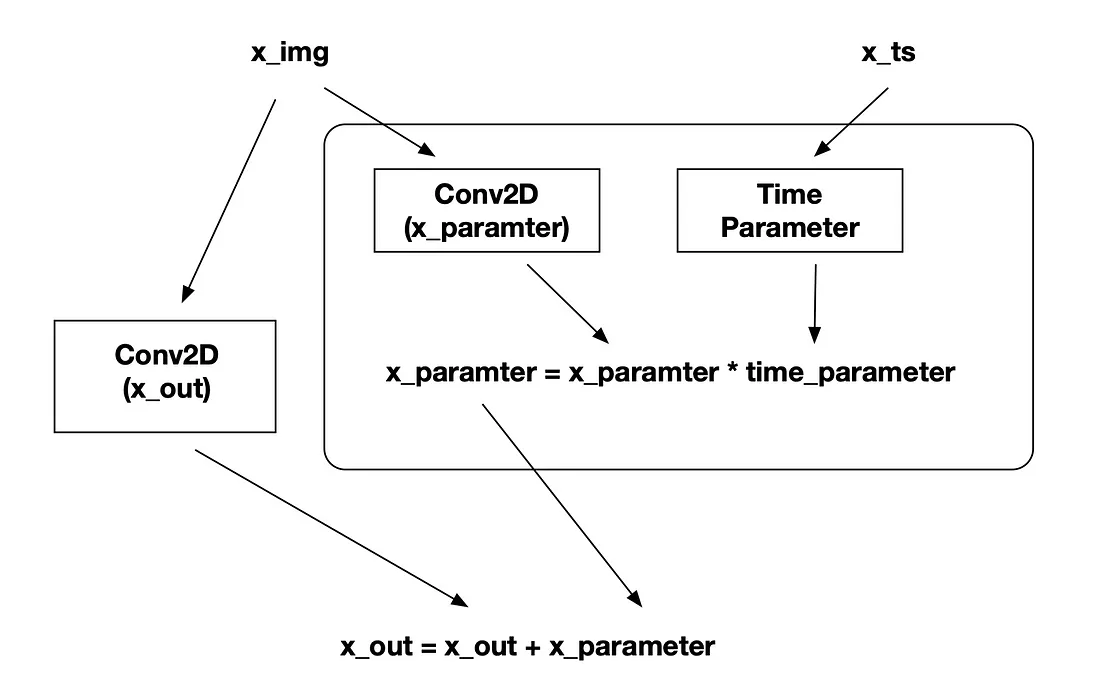

In [4]:
def block(x_img, x_ts):
    
    x_parameter = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_parameter = layers.Activation('relu')(x_parameter)

    time_parameter = layers.Dense(128)(x_ts)
    time_parameter = layers.Activation('relu')(time_parameter)
    time_parameter = layers.Reshape((1, 1, 128))(time_parameter)
    x_parameter = x_parameter * time_parameter
    
    # -----
    x_out = layers.Conv2D(128, kernel_size=3, padding='same')(x_img)
    x_out = x_out + x_parameter
    x_out = layers.LayerNormalization()(x_out)
    x_out = layers.Activation('relu')(x_out)
    
    return x_out

def make_model():
    x = x_input = layers.Input(shape=(28,28, 1), name='x_input')
    
    x_ts = x_ts_input = layers.Input(shape=(1,), name='x_ts_input')
    x_ts = layers.Dense(128)(x_ts)
    x_ts = layers.LayerNormalization()(x_ts)
    x_ts = layers.Activation('relu')(x_ts)
    
    # ----- left ( down ) -----
    x = x32 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x16 = block(x, x_ts)
    x = layers.MaxPool2D(2)(x)
    
    x = x8 = block(x, x_ts)
    
    # ----- MLP -----
    x = layers.Flatten()(x)
    x = layers.Concatenate()([x, x_ts])
    x = layers.Dense(128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)

    x = layers.Dense(7*7*128)(x)
    x = layers.LayerNormalization()(x)
    x = layers.Activation('relu')(x)
    x = layers.Reshape((7,7,128))(x)
    
    # ----- right ( up ) -----
    x = layers.Concatenate()([x, x8])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x16])
    x = block(x, x_ts)
    x = layers.UpSampling2D(2)(x)
    
    x = layers.Concatenate()([x, x32])
    x = block(x, x_ts)
    
    # ----- output -----
    x = layers.Conv2D(1, kernel_size=1, padding='same')(x)
    
    return tf.keras.models.Model([x_input, x_ts_input], x)

model = make_model()
model.summary()

2024-04-20 20:03:42.592361: I metal_plugin/src/device/metal_device.cc:1154] Metal device set to: Apple M2
2024-04-20 20:03:42.592377: I metal_plugin/src/device/metal_device.cc:296] systemMemory: 24.00 GB
2024-04-20 20:03:42.592381: I metal_plugin/src/device/metal_device.cc:313] maxCacheSize: 8.00 GB
2024-04-20 20:03:42.592406: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:303] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2024-04-20 20:03:42.592418: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:269] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 x_ts_input (InputLayer)     [(None, 1)]                  0         []                            
                                                                                                  
 dense (Dense)               (None, 128)                  256       ['x_ts_input[0][0]']          
                                                                                                  
 layer_normalization (Layer  (None, 128)                  256       ['dense[0][0]']               
 Normalization)                                                                                   
                                                                                                  
 activation (Activation)     (None, 128)                  0         ['layer_normalization[0][0

 tf.__operators__.add_2 (TF  (None, 7, 7, 128)            0         ['conv2d_5[0][0]',            
 OpLambda)                                                           'tf.math.multiply_2[0][0]']  
                                                                                                  
 layer_normalization_3 (Lay  (None, 7, 7, 128)            256       ['tf.__operators__.add_2[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 activation_9 (Activation)   (None, 7, 7, 128)            0         ['layer_normalization_3[0][0]'
                                                                    ]                             
                                                                                                  
 flatten (Flatten)           (None, 6272)                 0         ['activation_9[0][0]']        
          

 layer_normalization_7 (Lay  (None, 14, 14, 128)          256       ['tf.__operators__.add_4[0][0]
 erNormalization)                                                   ']                            
                                                                                                  
 activation_17 (Activation)  (None, 14, 14, 128)          0         ['layer_normalization_7[0][0]'
                                                                    ]                             
                                                                                                  
 up_sampling2d_1 (UpSamplin  (None, 28, 28, 128)          0         ['activation_17[0][0]']       
 g2D)                                                                                             
                                                                                                  
 concatenate_3 (Concatenate  (None, 28, 28, 256)          0         ['up_sampling2d_1[0][0]',     
 )        

In [5]:
optimizer = tf.keras.optimizers.Adam(learning_rate=0.0008)
loss_func = tf.keras.losses.MeanAbsoluteError()
model.compile(loss=loss_func, optimizer=optimizer)

4. Create our dataset. We add noise linearly to each image for total 1000 timesteps, and get the noisy image and noise for each corrosponding image and time step.

In [6]:
noised_imgs = []
noises = []
time = []

for j in Xt:
    for i in range(1000):
        noisy_im, noise = add_noise(j, np.array([i,]))
        noised_imgs.append(noisy_im[0])
        noises.append(noise)
        time.append(i)
        
noised_imgs = np.array(noised_imgs)
noises = np.array(noises)
time = np.array(time)

5. Fit the model with input as noisy image,time steps and output as noise.

In [8]:
model.fit([noised_imgs,time],noises,epochs=20)

Epoch 1/20


2024-04-20 20:03:43.843848: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


313/313 [==============================] - 29s 88ms/step - loss: 0.2502
Epoch 2/20
313/313 [==============================] - 27s 86ms/step - loss: 0.1371
Epoch 3/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0970
Epoch 4/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0809
Epoch 5/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0684
Epoch 6/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0617
Epoch 7/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0519
Epoch 8/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0502
Epoch 9/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0464
Epoch 10/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0432
Epoch 11/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0400
Epoch 12/20
313/313 [==============================] - 27s 86ms/step - loss: 0.0379
Epoch 13/20


6. Define the DDIM for inference to get our image from the model prediction noise.

In [9]:
def ddim(x_t, pred_noise, t, step_size):
    alpha_t_bar = np.reshape(np.take(alpha_bar, t), [-1, 1, 1, 1])
    alpha_t_minus_one = np.reshape(np.take(alpha_bar, t-step_size), [-1, 1, 1, 1])
        
    pred = (x_t - ((1 - alpha_t_bar) ** 0.5) * pred_noise)/ (alpha_t_bar ** 0.5)
    pred = (alpha_t_minus_one ** 0.5) * pred

    pred = pred + ((1 - alpha_t_minus_one) ** 0.5) * pred_noise
    return pred

inference_timesteps = 200
inference_range = range(0, timesteps, timesteps // inference_timesteps)
inf_step = timesteps // inference_timesteps

7. Make predictions

2024-04-20 20:13:11.176821: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:114] Plugin optimizer for device_type GPU is enabled.


STEP :  152


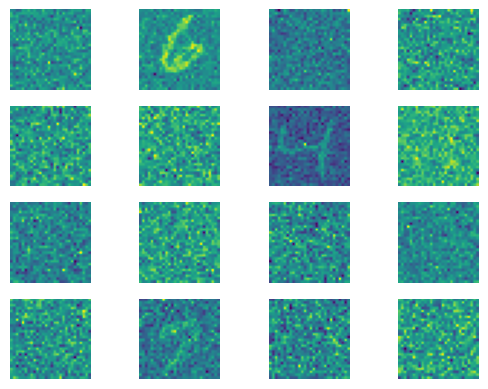

STEP :  102


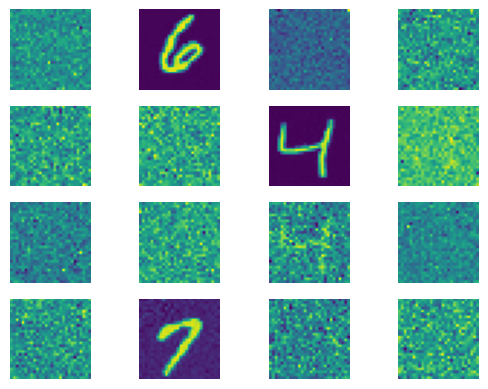

STEP :  52


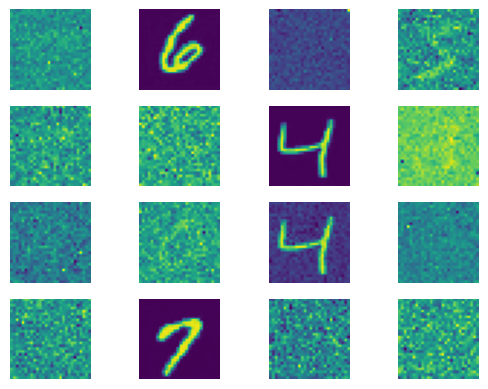

STEP :  2


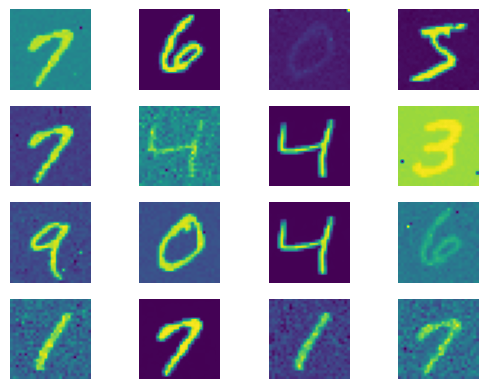

In [11]:
x = tf.random.normal((16,28,28,1))

for index, i in enumerate(reversed(range(inference_timesteps))):
    t = np.repeat(inference_range[i], 16)

    pred_noise = model.predict([x, np.full((16),  t)], verbose=0)
    x = ddim(x, pred_noise, t, inf_step)

    if any(t-inf_step) == 0:
        break
        
    if i%50 ==2:
        print('STEP : ',i)
        for j in range(x.shape[0]):
            axs = plt.subplot(4, 4, j+1)
            axs.imshow(x[j] * 0.5 + 0.5)
            plt.axis('off') 

        plt.show() 

STEP :  156


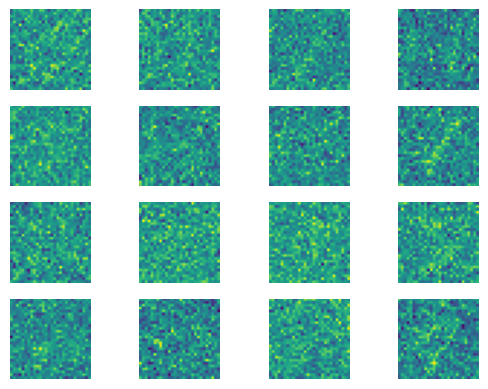

STEP :  106


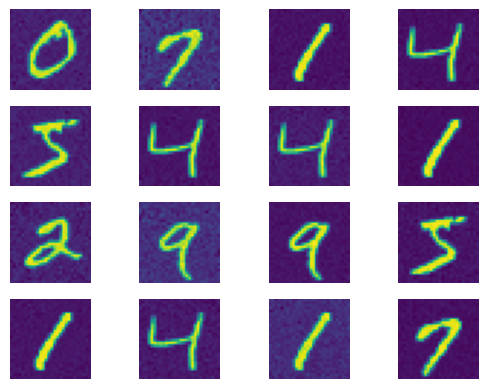

STEP :  56


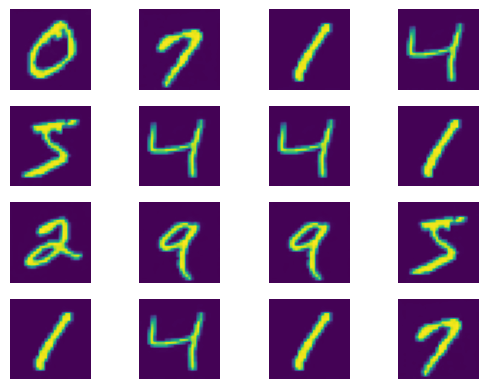

STEP :  6


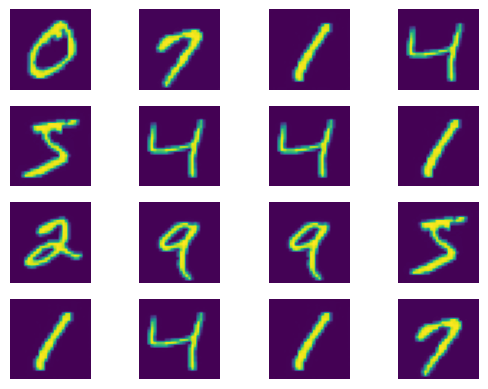

In [12]:
x = tf.random.normal((16,28,28,1))

for index, i in enumerate(reversed(range(inference_timesteps))):
    t = np.repeat(i, 16)

    pred_noise = model.predict([x, np.full((16),  t)], verbose=0)
    x = ddim(x, pred_noise, t, inf_step)

    if any(t-inf_step) == 0:
        break
        
    if i%50 ==6:
        print('STEP : ',i)
        for j in range(x.shape[0]):
            axs = plt.subplot(4, 4, j+1)
            axs.imshow(x[j] * 0.5 + 0.5)
            plt.axis('off') 

        plt.show() 